# Requirements

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses

import pathlib

import librosa
import librosa.display

from IPython.display import clear_output

autotune = tf.data.experimental.AUTOTUNE # solution to AttributeError: when using tf.data.AUTOTUNE

### ```GPU Configurment```

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            #tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*11)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1000761282785746636
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10319101952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 667334832768184260
physical_device_desc: "device: 0, name: NVIDIA TITAN V, pci bus id: 0000:09:00.0, compute capability: 7.0"
]


### ```Predefined Variables```

In [4]:
IMAGE_SIZE = 345*513
IMAGE_DIM = [345,513,1]

# Training
batch_size = 1

### ```Path Variables```

In [5]:
base_path = pathlib.Path('C:/Users/KSAI/jaewon_projectfolder/music-discern/') # Edit on other computers
base_path_dataset = pathlib.Path('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/') # Edit on other computers

#Urbansound is nested in Datasets/Urbansound8K/audio/fold**
#Urbansound is already separated into batches, which need to be preserved.
urban_metadata_path = pathlib.Path(base_path_dataset/'Urbansound8K/metadata')
urban_audio_folders_path = pathlib.Path(base_path_dataset/'Urbansound8K/processed')
urban_audio_path_list = [x for x in urban_audio_folders_path.iterdir()]
temp = urban_audio_path_list.pop(1)
urban_audio_path_list.append(temp)
urban_audio_path_list = urban_audio_path_list
#Jamendo is nested in Datasets/MTGJamendo/audio
#Jamendo is not separated in batches, so we need to separate it into 10 batches, matching urbansound.
jamendo_metadata_path = pathlib.Path(base_path_dataset/'MTGJamendo/metadata')
jamendo_audio_folders_path = pathlib.Path(base_path_dataset/'MTGJamendo/processed')
jamendo_audio_path_list = [x for x in jamendo_audio_folders_path.iterdir()]
temp = jamendo_audio_path_list.pop(1)
jamendo_audio_path_list.append(temp)
jamendo_audio_path_list = jamendo_audio_path_list

#for later -> add a path for any .wav file that I want to observe.
test_subjects_path = pathlib.Path("./")

save_weights_path = pathlib.Path(base_path/'Experiment1/model_checkpoints')
save_weights_A_path = pathlib.Path(save_weights_path/'model_A')
save_weights_B_path = pathlib.Path(save_weights_path/'model_B')

Train = [0,1,2,3,4,5,6,7,8]
Test = [9] #Seperation, for later evaluation in Training step B

print(urban_audio_path_list)
print(jamendo_audio_path_list)

[WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/processed/fold1'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/processed/fold2'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/processed/fold3'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/processed/fold4'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/processed/fold5'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/processed/fold6'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/processed/fold7'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/processed/fold8'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/Urbansound8K/processed/fold9'), WindowsPath('C:/Users/KSAI/jaewon_projectfolder/music-discern/Datasets/U

### ```Processing Functions(for mapping)```

In [6]:
def process_image(image):
    #make the images into spectrograms
    # processed_img = tf.pow(tf.abs(image),2) edited 2022-08-29, takes to much ram, so done in the preprocessing step.
    processed_img = image
    #normalize the images?
    return processed_img

def process_path_A(path):
    #for training A, the label is just itself so we need to take that into account
    img = tf.io.read_file(path)
    img = tf.io.decode_raw(img,tf.float32)#this changes too, 2022-08-29
    img = tf.slice(img,begin=[1024//32],size=[IMAGE_SIZE]) # begin <- 1024//complex64
    img = tf.reshape(img,IMAGE_DIM)
    img = process_image(img)

    label = img
    return img, label

"""
def process_a(file_path):
    n = np.load(file_path)
    return np.reshape(n,[345,513,1])

process_path_A = lambda input : tf.numpy_function(process_a, [input], [tf.float32])
"""
def process_path_B(path): #map_func
    #extract the 2d array and the label
    img = tf.io.read_file(path)
    img = tf.io.decode_raw(img,tf.float32) #this changes too, 2022-08-29
    img = tf.slice(img,begin=[1024//32],size=[IMAGE_SIZE]) # begin <- 1024//complex64
    img = tf.reshape(img,IMAGE_DIM)
    img = process_image(img)

    label = tf.strings.split( tf.strings.split( path, os.sep )[-1],sep="_" )[1]
    return img, label

# Create Datasets

### ```Initialize Datasets```

In [7]:
dataset_for_training_A = "empty"
dataset_for_training_B_train = "empty"
dataset_for_training_B_test = "empty"

dataset_for_training_A = tf.data.Dataset.list_files(str(urban_audio_folders_path/'*/*.npy'))
dataset_for_training_A = dataset_for_training_A.concatenate( tf.data.Dataset.list_files(str(jamendo_audio_folders_path/'*/*.npy')) )

for k in Train:
    temp_path_urban = str(urban_audio_path_list[k])
    temp_path_jam = str(jamendo_audio_path_list[k])
    if dataset_for_training_B_train == "empty":
        dataset_for_training_B_train = tf.data.Dataset.list_files(temp_path_urban + '/*.npy')
        dataset_for_training_B_train = dataset_for_training_B_train.concatenate( tf.data.Dataset.list_files(temp_path_jam + '/*.npy') )
    else:
        dataset_for_training_B_train = dataset_for_training_B_train.concatenate( tf.data.Dataset.list_files(temp_path_urban + '/*.npy') )
        dataset_for_training_B_train = dataset_for_training_B_train.concatenate( tf.data.Dataset.list_files(temp_path_jam + '/*.npy') )

for k in Test:
    temp_path_urban = str(urban_audio_path_list[k])
    temp_path_jam = str(jamendo_audio_path_list[k])
    if dataset_for_training_B_test == "empty":
        dataset_for_training_B_test = tf.data.Dataset.list_files(temp_path_urban + '/*.npy')
        dataset_for_training_B_test = dataset_for_training_B_test.concatenate( tf.data.Dataset.list_files(temp_path_jam + '/*.npy') )
    else:
        dataset_for_training_B_test = dataset_for_training_B_test.concatenate( tf.data.Dataset.list_files(temp_path_urban + '/*.npy') )
        dataset_for_training_B_test = dataset_for_training_B_test.concatenate( tf.data.Dataset.list_files(temp_path_jam + '/*.npy') )

# returns dataset for training A, dataset for training B Train, dataset for training B Test

### ```Map the Datasets with processing functions```

In [8]:
dataset_A = dataset_for_training_A.map(process_path_A,num_parallel_calls=autotune)
dataset_B_train = dataset_for_training_B_train.map(process_path_B,num_parallel_calls=autotune)
dataset_B_test = dataset_for_training_B_test.map(process_path_B,num_parallel_calls=autotune)

### ```Configure for Performance```

In [9]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=autotune)
    return ds

dataset_A = configure_for_performance(dataset_A)
dataset_B_test = configure_for_performance(dataset_B_test)
dataset_B_train = configure_for_performance(dataset_B_train)

# Create Models/Callbacks

### ```Create Autoencoder(Model A)```

In [10]:
class Autoencoder(tf.keras.Model):
#when the input shape is an odd number, even number of strides coupled with 'same' padding makes the output shape different from the imput shape.
#Therefore by trial and error this valid, same, valid, valid, valid padding structure was found, not sure if it is accurate
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape = IMAGE_DIM , batch_size= batch_size),
            layers.Conv2D(16, (3,3), activation='relu', padding='valid', strides=2),
            layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2), 
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='valid'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='valid'),
            layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='valid') 
        ])
    
    def __call__(self, x, training=False):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
Model_A = Autoencoder()

### ```Create Classifier(Model B)```

In [11]:
class Classifier(tf.keras.Model):

    def __init__(self, Model_A):
        super(Classifier, self).__init__()
        #comes after the encoding
        self.classifer_layer = tf.keras.Sequential([
            layers.InputLayer(input_shape=[128,86,8], batch_size= batch_size),
            layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(4, (3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(2, (3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(1, (3,3), activation='relu', padding='same', strides=2),
            layers.Flatten(),
            layers.Dense(16, activation='relu'),
            layers.Dense(1, activation='softmax')
        ])
        self.Model_A = Model_A.encoder # Probablility of deepcopy, not sure. If accuracy is terrible this may be the suspect

    def __call__(self,x, training=False):
        compressed = self.Model_A(x)
        return self.classifer_layer(compressed)

Model_B = Classifier(Model_A)

### ```Compile the Models```

In [12]:
Model_A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.keras.losses.MeanSquaredError())

In [13]:
Model_B.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### ```Create Custom Callbacks```

In [14]:
# Create a callback function that saves the weights periodically, and shows the reconstructed images periodically
from IPython.display import clear_output

class Monitor_A(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        #_, ax = plt.subplots(1,2, figsize=(21,7)
        #for k,k in dataset_A.take(1):
        #    changed = self.model(k)
        #    clear_output(wait=True)
        #    ax[0].imshow(k[0])
        #    ax[1].imshow(changed[0])
        #    ax[0].set_title("Input image")
        #    ax[1].set_title("Translated image")
        #    ax[0].axis("off")
        #    ax[1].axis("off")
        
        for k,k in dataset_A.take(1):
            plt.figure(figsize=(21, 5))

            n_fft = 1024
            hop_length = n_fft//4 #256
            sr = 22050
            plt.subplot(1, 2, 1)
            librosa.display.specshow(tf.reshape(k[0],[345,513]).numpy(), sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
            plt.colorbar(format='%+2.0f dB')

            plt.subplot(1, 2, 2)
            changed = self.model(k)
            librosa.display.specshow(tf.reshape(changed[0],[345,513]).numpy(), sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
            plt.colorbar(format='%+2.0f dB')

        if (epoch) % 5 == 0:
            self.model.save_weights(pathlib.Path(save_weights_A_path/"{epoch:04}.h5"))
        clear_output(wait=True)
        plt.show()
        plt.close()

In [15]:
# Create a callback function that saves the weights periodically, and shows the reconstructed images periodically
class Monitor_B(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        if (epoch) % 5 == 0:
            self.model.save_weights(pathlib.Path(save_weights_B_path/"{epoch:04}.h5"))

# Training with model.fit

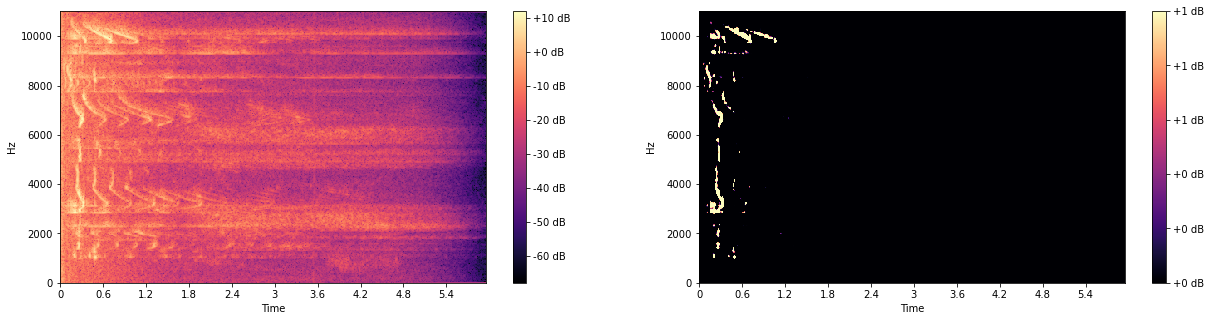

Epoch 2/20
38645/41026 [===========================>..] - ETA: 16s - loss: 332.0312

In [16]:
with tf.device('/gpu:0'):
    history = Model_A.fit(dataset_A, batch_size=10, epochs=20, callbacks=[Monitor_A()])

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
#plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
with tf.device('/gpu:0'):
    history = Model_B.fit(dataset_B_train, batch_size=batch_size, epochs=100, callbacks=[Monitor_B()], validation_data=dataset_B_test)